<a href="https://colab.research.google.com/github/AnushkaBorah/Twitter-Sentiment-Analysis-using-TFIDF-/blob/main/Twiiter_Sentiment_Analysis_using_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download stopwords if not already available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
train_file_path = '/content/drive/MyDrive/AI LAB/ANUSHKA_BORAH_LAB2/training.1600000.processed.noemoticon.csv'
test_file_path = '/content/drive/MyDrive/AI LAB/ANUSHKA_BORAH_LAB2/test.xlsx'

# Loading train data

In [ ]:
# Load the dataset
df = pd.read_csv(train_file_path, delimiter=',', encoding='ISO-8859-1')  # Replace with file path
train_data = df.copy()
train_data.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Checking meaning of labels
## 4==positive, 0==negative

train_data[train_data['polarity of tweet\xa0']==4].head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
799996,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
799997,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
799998,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
799999,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800000,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


# Exploratory Data Analysis, Preprocessing and Data Cleanup

In [ ]:
# looking for null values in data
## no null values found

print(train_data.shape[0],'\n\n\n\n')
train_data.info()

1048572 




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   polarity of tweet   1048572 non-null  int64 
 1   id of the tweet     1048572 non-null  int64 
 2   date of the tweet   1048572 non-null  object
 3   query               1048572 non-null  object
 4   user                1048572 non-null  object
 5   text of the tweet   1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [ ]:
# looking for duplicate rows
## no duplicate values found

train_data.duplicated().sum()

0

In [ ]:
# id column is found to repeat
print(train_data['id of the tweet'].nunique()==train_data.shape[0])

# upon further inspection, anomaly is found in data
## 531 same instances are present which are tagged both the labels even if the content is exactly same. Keeping these rows will confuse the model, hence removing them.
train_data[['id of the tweet', 'date of the tweet', 'user','text of the tweet\xa0']].duplicated().sum()

False


531

In [ ]:
repeat_values = train_data['id of the tweet'].value_counts() # Count how many times each tweet ID appears in the dataset
repeated_ids = repeat_values[repeat_values > 1].index # Get the tweet IDs that appear more than once (i.e., duplicated IDs)
repeated_rows = train_data[train_data['id of the tweet'].isin(repeated_ids)] # Select the rows from the dataset where the tweet ID is in the list of duplicated IDs
repeated_rows.sort_values(by='id of the tweet') # Sort the repeated rows by the tweet ID (for clarity or inspection purposes)

train_data = train_data[~(train_data['id of the tweet'].isin(repeated_ids))] # Remove the rows with repeated tweet IDs from the original dataset


train_data.drop('id of the tweet', axis=1, inplace=True) # Drop the 'id of the tweet' column from the dataset since it is no longer needed

In [ ]:
# looking for constant columns
## query is a constant column and therefore won't provide any information. Hence, we will be dropping this column.

for col in train_data.columns:
  if train_data[col].value_counts().shape[0]==1:
    print(col)

# dropping date and user column as it also logically does not contribute to sentiment analysis of the tweet
train_data.drop(['query','date of the tweet','user'], axis=1, inplace=True)


query


In [ ]:
# Cleaning up 'text of the tweet'

## removing usernames and special characters from tweet using regex

def process_tweet(tweet):
  return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", "",tweet.lower()).split())

train_data['text of the tweet\xa0'] = train_data['text of the tweet\xa0'].apply(process_tweet)

In [ ]:
 # Preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to the 'text' column
train_data['text of the tweet\xa0'] = train_data['text of the tweet\xa0'].apply(preprocess_text)

In [ ]:
# Extract unique words
all_words = ' '.join(train_data['text of the tweet\xa0']).split()
unique_words = set(all_words)
print(f"Number of unique words: {len(unique_words)}")

Number of unique words: 361800


In [ ]:
train_data.head()

,polarity of tweet,text of the tweet
0,0,upset cant update facebook texting might cry r...
1,0,dived many times ball managed save 50 rest go ...
2,0,whole body feels itchy like fire
3,0,behaving im mad cant see
4,0,whole crew


<Axes: xlabel='polarity of tweet\xa0', ylabel='count'>

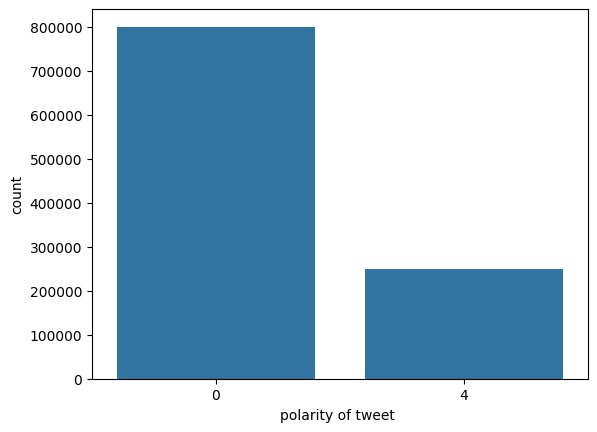

In [ ]:
#Let's see some visuals
sns.countplot(x=df['polarity of tweet\xa0'])

# Training and Test split

In [ ]:
train_data.reset_index(drop=True, inplace=True) # Reset the index of the DataFrame after removing duplicate rows and dropping the 'id of the tweet' column

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_data["text of the tweet\xa0"],train_data["polarity of tweet\xa0"], test_size = 0.2, random_state = 3)
# Split the data into training and testing sets, # Features: the text of the tweets,  # Target: the polarity (e.g., sentiment labels),  # Use 20% of the data for testing,  # Set a random seed for reproducibility

In [ ]:
train_data.rename(columns=lambda x: x.strip(), inplace=True)
Xfile = "Xfile.csv"  # File name for features
train_data["text of the tweet"].to_csv(Xfile, index=False, header=False)
Yfile = "Yfile.csv"  # File name for labels
train_data["polarity of tweet"].to_csv(Yfile, index=False, header=False)

In [ ]:
x_train.shape[0], y_train.shape[0], x_test.shape[0], y_test.shape[0]


(838008, 838008, 209502, 209502)

# Transforming using tfidf

In [ ]:
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
## for transforming the 80% of the train data ##
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
## for transforming the 20% of the train data which is being used for testing ##
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

# Classification model implementation

In [ ]:
model = RandomForestClassifier(n_estimators=50)
model.fit(x_train_tfidf, y_train)

RandomForestClassifier(n_estimators=50)

In [ ]:
predictions = model.predict(x_train_tfidf) # Generate predictions on the training data using the trained model
print(accuracy_score(y_train, predictions)) # Calculate and print the accuracy of the model on the training data

0.9918783591564758


In [ ]:
y_pred = model.predict(x_test_tfidf) # Generate predictions on the test data using the trained model
print(accuracy_score(y_test, y_pred)) # Calculate and print the accuracy of the model on the test data

0.819705778465122


In [ ]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89    160089
           4       0.74      0.37      0.49     49413

    accuracy                           0.82    209502
   macro avg       0.78      0.66      0.69    209502
weighted avg       0.81      0.82      0.80    209502

Accuracy: 0.82


# TEST DATA: Preprocessing

In [ ]:
# Correctly read the Excel file
test = pd.read_excel(test_file_path)  # Encoding is optional and may not be necessary
test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346,652860,60
1,96d74cb729,Shanghai is also really exciting (precisely --...,positive,noon,21-30,Albania,2877797,27400,105
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044,2381740,18
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265,470,164
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272,1246700,26


In [ ]:
test['sentiment'].value_counts()

,count
sentiment,
neutral,1430
positive,1103
negative,1001


In [ ]:
# Encoding the target column

test['encoded_sentiment'] = test['sentiment'].replace({'positive': 4, 'negative': 0, 'neutral': 2})
test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),encoded_sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346,652860,60,2
1,96d74cb729,Shanghai is also really exciting (precisely --...,positive,noon,21-30,Albania,2877797,27400,105,4
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044,2381740,18,0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265,470,164,4
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272,1246700,26,4


In [ ]:
test = test[['text', 'encoded_sentiment']]

In [ ]:
test['encoded_sentiment'].value_counts(1)

,proportion
encoded_sentiment,
2,0.404641
4,0.312111
0,0.283248


In [ ]:
## removing usernames from tweet using regex
test['text'] = test['text'].apply(process_tweet)
# Apply preprocessing to the 'text' column
test['text'] = test['text'].apply(preprocess_text)

In [ ]:
test.reset_index(drop='True', inplace=True) # Reset the index of the test DataFrame for consistency after preprocessing

X_test, Y_test = test['text'], test['encoded_sentiment'] # Separate the text data (features) and encoded sentiment labels (target) into X_test and Y_test

In [ ]:
X_test_counts = count_vect.transform(X_test) # Convert the test text data into a document-term matrix using the trained CountVectorizer
X_test_tfidf = transformer.transform(X_test_counts) # Convert the document-term matrix into a TF-IDF representation using the trained TfidfTransformer

# TEST DATA: Prediction

In [ ]:
predictions = model.predict(X_test_tfidf)
print(accuracy_score(Y_test, predictions))# includes 40 percent new label

0.4790605546123373


In [ ]:
# Evaluate the model
print("Classification Report:")
print(classification_report(Y_test, predictions))
print(f"Accuracy: {accuracy_score(Y_test, predictions):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.88      0.59      1001
           2       0.00      0.00      0.00      1430
           4       0.53      0.73      0.62      1103

    accuracy                           0.48      3534
   macro avg       0.32      0.54      0.40      3534
weighted avg       0.29      0.48      0.36      3534

Accuracy: 0.48


In [ ]:
test['predicted_sentiment'] = predictions

In [ ]:
df = test[test['encoded_sentiment']!=2] #without the neutral label since it was not in training datatset
print(accuracy_score(df['encoded_sentiment'], df['predicted_sentiment']))

0.8046577946768061


In [ ]:
# Evaluate the model
print("Classification Report:")
print(classification_report(df['encoded_sentiment'], df['predicted_sentiment']))
print(f"Accuracy: {accuracy_score(df['encoded_sentiment'], df['predicted_sentiment']):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1001
           4       0.87      0.73      0.80      1103

    accuracy                           0.80      2104
   macro avg       0.81      0.81      0.80      2104
weighted avg       0.82      0.80      0.80      2104

Accuracy: 0.80
